In [1]:
#@title Install prerequsite

!pip install lifelines

     |████████████████████████████████| 389kB 2.9MB/s 


In [2]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Predicting Progression Free Survival of TCGA NSCLC Patients: Getting Started

This notebook serves as a getting started template for you to start working on building your awesome model for predicting progression free survival (PFS). We will go through some basic exploratory data analysis (EDA), and build a baseline model that you can modify from. Remember the following timeline:

* 2019-10-27 11:59 PM First checkpoint
* 2019-11-04 11:59 PM Second checkpoint
* 2019-11-11 11:59 PM Final submission

In each checkpoint, you can submit your prediction and get it scored against the test set. The final ranking will be **based on the best score among your up-to-three submissions**. 

## Exploratory data analysis (EDA)

First let's take a look at the data. You can find the challenge data at the following location:

[mini-challenge](https://docs.google.com/presentation/d/1QF9X2lEOQndKUPFYwjFZSITe8ifOnExtjet5Zw88nmI/edit#slide=id.g622cd406a7_0_0)

It should contain the following files:

* `clinical_train`: Clinical information of each patient in the trianing set
* `clinical_test`: Clinical information of each patient in the test set
* `rnaseq_train`: Normalized voom values of RNASeq data of each patient in the trianing set
* `rnaseq_test`: Normalized voom values of RNASeq data of each patient in the test set
* `mut_train`: Mutation information as MAF file format of each patient in the training set
* `mut_test`: Mutation information as MAF file format of each patient in the test set
* `pfs_train`: Progression-free survival of each patient in the training set. **This is your target variables**.

Note there is no `pfs_test` as it is what you are supposed to predict and being scored upon.

In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("data")

### Progression-free survival

The [progression-free survival](https://en.wikipedia.org/wiki/Progression-free_survival) (PFS) measures the amount of time from a starting point (in our case, when the primary tumor sample is taken), to the time when the tumor has progressed (tumor grows or metastasizes). It is a [**right-censored**](https://en.wikipedia.org/wiki/Censoring_(statistics)) data as some of the patients may be out of contact or are still alive at the time the data was generated. 

The PFS info is encoded in two columns: an `event` column indicating whether an event (in this case, progression) has occurred, and also a `time_to_event` column indicating how much time has the subject been under observation. These two columns can be used to perform survival analysis.

In [4]:
import pandas as pd

pfs_train = pd.read_csv(DATA / "pfs_train.txt", sep="\t", index_col="patient_id")
pfs_train.head()

,progression,time_to_progression_or_censor
patient_id,,
TRAIN_0000,1.0,334.0
TRAIN_0001,0.0,1523.0
TRAIN_0002,0.0,121.0
TRAIN_0003,1.0,334.0
TRAIN_0004,1.0,183.0


As part of EDA, we can first construct the overall survival curve using the `lifelines` package.

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(pfs_train.time_to_progression_or_censor, pfs_train.progression)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 816 total observations, 525 right-censored observations>

The `KaplanMeierFitter` fit the survival data using the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), or a product-limit estimator, which estimate the survival function at each time point when an event occurrs:

$$
\hat{S}(t) = \prod_{t_i < t}{\frac{n_i - d_i}{n_i}}
$$

where $d_i$ is the number of death events at $t$ and $n_i$ is the number at risk at prior to time $t$.

Once the estimator fits the data, you can plot the survival curve by:

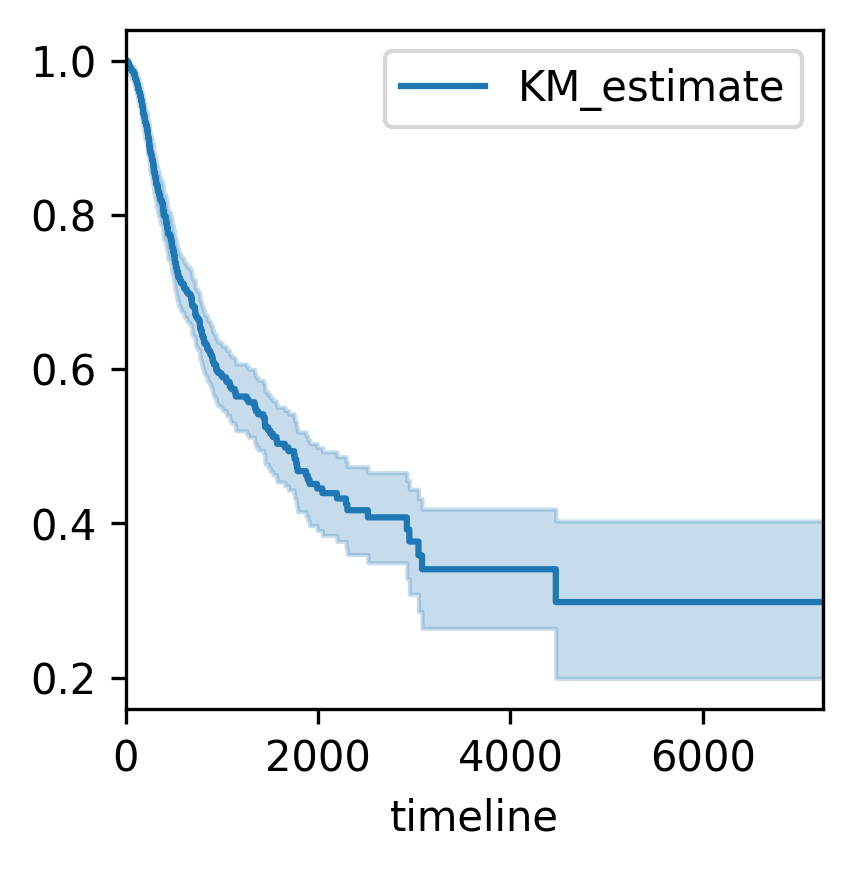

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300, figsize=(3, 3))
kmf.plot(ax=ax)

This plot gives us an overview of the PFS across the population, with the confidence interval. We can also get the median survival of the population by:

In [7]:
print("Median survival time of the population is {}".format(
    kmf.median_survival_time_)
)

Median survival time of the population is 1655.0


### Clinical data

Regarding the features we will be using to predict survival, take a look at the clinical table:

In [8]:
clin_train = pd.read_csv(DATA / "clinical_train.txt", sep="\t", index_col="patient_id")

# also load clin_test
clin_test = pd.read_csv(DATA / "clinical_test.txt", sep="\t", index_col="patient_id")

clin_train.head()

,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,diagnosis,eastern_cancer_oncology_group,ethnicity,gender,karnofsky_performance_score,laterality,location_in_lung_parenchyma,number_pack_years_smoked,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,race,radiation_therapy,residual_tumor,tobacco_smoking_history
patient_id,,,,,,,,,,,,,,,,,,
TRAIN_0000,81,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],32,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0001,67,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],Peripheral Lung,52,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,3
TRAIN_0002,79,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],FEMALE,[Not Available],[Not Available],[Not Available],47,M0,N1,T3,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0003,68,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],62,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,4
TRAIN_0004,66,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],20,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],RX,3


NP - m-metasthesis, n-lymph nodes, t-tumor size, pathologic stage combines the 3

Now with more detailed clinical information, we can see that our data set consists of patients from two main cancer category: `Lung Adenocarcinoma` (LUAD) and `Lung Squamous Cell Carcinoma` (LUSC) (the `diagnosis` column). Let's see if the two tumor types have different PFS profiles.

We can perform a simple uni-variate [Cox Proportional Hazard (PH) model](https://en.wikipedia.org/wiki/Proportional_hazards_model) fitting to compare the survival difference between LUAD and LUSC patient population. The Cox PH model assumes that one-unit change of the feature has a multiplicative effect on the hazard function (effectively the survival function):

$$
\lambda(t|X_i) = \lambda_0(t)\exp(\beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p)
$$

The $\lambda_0(.)$ is a baseline hazard function, and will be eliminated when we compare the hazard ratio between two subjects (or populations) with different covariate values ($X_i$'s).

To perform uni-variate Cox PH modeling, we can use the `CoxPHFitter` in the `lifelines` package:

In [9]:
# First construct a data frame with all the variables needed
mat = pd.concat([pfs_train.copy(), clin_train[["diagnosis"]]],
                axis=1, sort=True)
# convert the diagnosis to whether the patient is LUAD
mat["diagnosis"] = mat.diagnosis == "Lung Adenocarcinoma"
mat.rename(columns={"diagnosis": "LUAD"}, inplace=True)

mat.head()

,progression,time_to_progression_or_censor,LUAD
patient_id,,,
TRAIN_0000,1.0,334.0,True
TRAIN_0001,0.0,1523.0,True
TRAIN_0002,0.0,121.0,True
TRAIN_0003,1.0,334.0,True
TRAIN_0004,1.0,183.0,True


In [10]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')

<lifelines.CoxPHFitter: fitted with 816 total observations, 525 right-censored observations>

The `fit` function will fit all the columns other than the two you assigned as `duration_col` and `event_col` to the model. Therefore, be careful what you leave in the data frame.

Once the fitting is done, we can check the `summary` field on the association between your variables and survival.

In [11]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
LUAD,0.43944,1.551837,0.119613,0.205002,0.673878,1.227527,1.96183,3.673835,0.000239,12.031079


We can see that LUAD has higher hazard (`coef` > 0), which means the LUAD population has shorter average PFS than the LUSC population, with very significant _P_ value. 

Another way to quantify the significance of the association, is to use the [concordance index](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-based-on-predictive-power), which is also the score we'll be using to evaluate your models. The concordance index compares all _comparable_ pairs of patients in the population, and records the proportion of pairs that has the same order between the predicted values and the survival. See [this article](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7) for detailed information.

The concordance index can be obtained from the `score_` field from a fitted `CoxPHFitter` object. As the `score_` is calculating the concordance with **hazard**, we will need to calculate `1 - score_` to get the concordance index with survival time.

In [12]:
print("The concordance index between tumor type and PFS is {:.4f}".format(
    1 - cph.score_
))

The concordance index between tumor type and PFS is 0.4498


The concordance index is less than 0.5, which means it negatively correlates with _survival time_ (thus positively correlates with _hazard_). The categorical variables generally would have lower concordance index with survival than original numerical variables due to the handling of ties in the calculation.

To visualize this is to plot two separate Kaplan-Meier survival curves for the two populations:

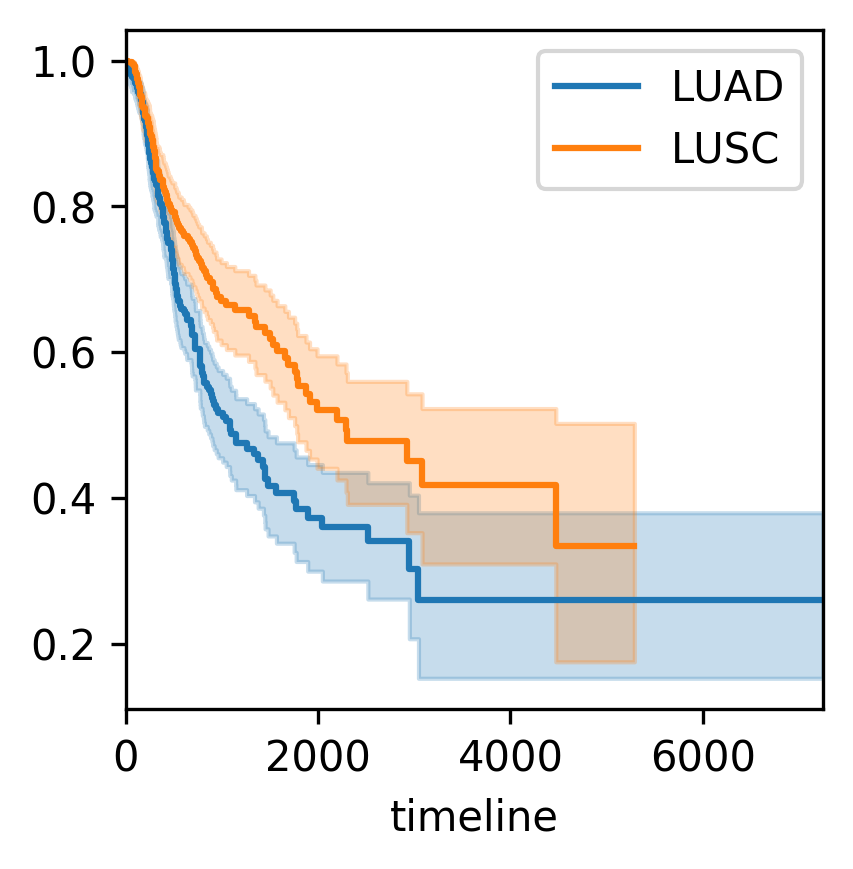

In [13]:
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

luad_idx = mat.LUAD
kmf.fit(mat.time_to_progression_or_censor[luad_idx], mat.progression[luad_idx],
        label="LUAD")
kmf.plot(ax=ax)
kmf.fit(mat.time_to_progression_or_censor[~luad_idx],
        mat.progression[~luad_idx],
        label="LUSC")
kmf.plot(ax=ax)

The next step is to pre-process the clinical table so it is machine learning ready. To do that, we need to convert the categorical variables into something numerical, one simple way to do that is to use [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179). So we will try to identify categorical variables in our data and perform one-hot encoding transformation.

You can see from above that our clinical table is a mixture of continuous variables (_e.g._ `age_at_initial_pathologic_diagnosis`) and categorical variables (_e.g._ `gender`, `diagnosis`). First let's do a simple scan to determine for each column what is its cardinality and if they are categorical, what are their individual values.

NP - threshold of 20 to check whether variable is continuous or categorical

In [0]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="force")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [0]:
#cat_cont_summary_for_df(clin_train)

We can see the determination is not perfect. We can then do some post-processing to fix some issue. 

First we want to convert all the `[Not Available]`, `[Unknown]`, `[Not Evaluable]` to `np.NaN`.

In [0]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])


After this process, we can see the values in brackets are all converted to `np.NaN`

In [0]:
#cat_cont_summary_for_df(clin_train)

The following code selected a few columns of interests (arbitrarily), convert the categorical variables to [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179), then these data frames are machine-learning ready.

In [0]:
cat_cols = ["diagnosis", "location_in_lung_parenchyma", "pathologic_M",
            "pathologic_N", "pathologic_T", "radiation_therapy",
            "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "number_pack_years_smoked"]

In [0]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

In [20]:
x_clin_train.head()

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX,age_at_initial_pathologic_diagnosis,number_pack_years_smoked
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,81,32
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,52
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,79,47
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,68,62
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,66,20


In [0]:
x_clin_train_mod = x_clin_train.copy()
x_clin_test_mod = x_clin_test.copy()

In [0]:
# modification of clinical data

def modify(x_clin):
  M = x_clin.iloc[:,4:9]
  N = x_clin.iloc[:,9:14]
  T = x_clin.iloc[:,14:23]
  R = x_clin.iloc[:,25:29]

  for i in range(len(M.columns)):
    M.iloc[:,i] *= (i+1)

  for i in range(len(N.columns)):
    N.iloc[:,i] *= (i+1)

  for i in range(len(T.columns)):
    T.iloc[:,i] *= (i+1)

  for i in range(len(R.columns)):
    R.iloc[:,i] *= (i+1)

  x_clin["pathologic_M"] = M.sum(axis=1)
  x_clin["pathologic_N"] = N.sum(axis=1)
  x_clin["pathologic_T"] = T.sum(axis=1)
  #x_clin["pathologic_R"] = R.sum(axis=1)

  #x_clin = x_clin.drop(x_clin_train_mod.columns[25:29], axis=1)
  x_clin = x_clin.drop(x_clin_train_mod.columns[4:23], axis=1)

  return x_clin

In [0]:
x_clin_train_mod = modify(x_clin_train_mod)
x_clin_test_mod = modify(x_clin_test_mod)

In [0]:
#x_clin_train = x_clin_train_mod
#x_clin_test = x_clin_test_mod

In [25]:
x_clin_train

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX,age_at_initial_pathologic_diagnosis,number_pack_years_smoked
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,81,32
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,52
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,79,47
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,68,62
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,66,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_0811,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,75,1
TRAIN_0812,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,63,2.5
TRAIN_0813,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,71,2.5


In [0]:
#x_clin_train = x_clin_train.drop(x_clin_train_mod.columns[4:10], axis=1)

NP- added code above to show 1/0 matrix

### RNASeq data

RNASeq data is very straight-forward. We have ~37,000 gene's expression values, all of them are log2 transformed, continuous values. 

In [27]:
ge_train = pd.read_csv(DATA / "rnaseq_train.txt", sep="\t", index_col=0)
ge_test = pd.read_csv(DATA / "rnaseq_test.txt", sep="\t", index_col=0)

ge_train.head()

,TRAIN_0001,TRAIN_0002,TRAIN_0003,TRAIN_0004,TRAIN_0005,TRAIN_0006,TRAIN_0007,TRAIN_0008,TRAIN_0009,TRAIN_0010,TRAIN_0011,TRAIN_0012,TRAIN_0013,TRAIN_0014,TRAIN_0015,TRAIN_0016,TRAIN_0017,TRAIN_0018,TRAIN_0019,TRAIN_0020,TRAIN_0021,TRAIN_0022,TRAIN_0023,TRAIN_0024,TRAIN_0025,TRAIN_0026,TRAIN_0027,TRAIN_0028,TRAIN_0029,TRAIN_0030,TRAIN_0031,TRAIN_0032,TRAIN_0033,TRAIN_0034,TRAIN_0035,TRAIN_0036,TRAIN_0037,TRAIN_0038,TRAIN_0039,TRAIN_0040,...,TRAIN_0776,TRAIN_0777,TRAIN_0778,TRAIN_0779,TRAIN_0780,TRAIN_0781,TRAIN_0782,TRAIN_0783,TRAIN_0784,TRAIN_0785,TRAIN_0786,TRAIN_0787,TRAIN_0788,TRAIN_0789,TRAIN_0790,TRAIN_0791,TRAIN_0792,TRAIN_0793,TRAIN_0794,TRAIN_0795,TRAIN_0796,TRAIN_0797,TRAIN_0798,TRAIN_0799,TRAIN_0800,TRAIN_0801,TRAIN_0802,TRAIN_0803,TRAIN_0804,TRAIN_0805,TRAIN_0806,TRAIN_0807,TRAIN_0808,TRAIN_0809,TRAIN_0810,TRAIN_0811,TRAIN_0812,TRAIN_0813,TRAIN_0814,TRAIN_0815
A1BG,-1.3364,-1.7668,-1.0198,-0.8983,-5.9363,0.3527,-3.0055,-2.3069,-2.1904,-1.2656,-1.3568,-0.7001,-2.8087,-1.0790,-1.5845,-1.2057,-1.6855,-1.1610,0.4233,-3.0186,-1.7536,-1.3744,-0.7374,-4.0285,-3.9233,-3.0484,-1.3048,-2.3104,-3.3131,-4.6724,-2.4712,-2.6891,-4.0212,-3.2784,-1.4477,-3.3057,-1.9225,-3.4339,-2.0238,-1.0988,...,-1.5283,-1.3231,-0.9713,-0.9121,-0.9251,-1.0919,0.2249,-0.6211,-3.3718,-2.0011,-0.9321,-1.0119,-1.3776,-1.4497,-2.0486,-3.0911,0.6557,0.4914,-0.1059,1.1786,-1.9261,-0.4090,-0.3578,-1.9184,0.4643,0.5011,-3.6151,-2.0062,-1.6154,-1.8095,-0.3868,0.4650,0.6863,-1.3412,-0.3093,-0.5301,-1.9589,-3.5359,-1.4197,-1.5915
A1BG-AS1,1.7801,0.7311,1.3790,1.4652,-1.1814,2.4569,-0.3547,0.1567,-0.4160,0.1432,1.0081,1.3865,0.2076,0.8685,-0.4850,1.6472,1.0725,2.1088,1.9816,-0.6165,-0.1687,1.0956,2.0803,-0.5321,-0.7533,0.3515,0.6253,1.5405,0.9846,-1.1280,0.6834,0.9465,-1.7841,0.5763,1.3927,-1.0927,0.3995,-1.5358,0.9184,2.0496,...,1.1689,0.9989,1.5540,1.3656,1.4299,0.8419,2.1225,1.1096,-0.4218,1.5061,1.0749,1.8351,0.4968,1.0799,0.6248,-0.1076,2.4359,2.0764,2.0007,3.6502,0.1443,2.3077,1.1210,0.4837,2.2172,2.0787,0.0854,0.3697,0.9461,0.9194,1.0042,2.7258,3.2015,1.5483,2.0472,1.6936,-0.0731,-1.6099,0.9022,0.3975
A1CF,-4.3104,-6.9762,-6.0047,-2.7964,1.4124,-6.1761,-7.6493,-1.7065,-4.1164,-6.1236,-5.4997,-5.0364,-6.2681,-2.1363,0.8936,-3.2891,4.6606,-3.7933,-3.4446,3.3810,-5.8411,-4.2620,-4.7193,-6.8359,-5.5082,-6.2184,-4.9292,-5.1178,-6.4830,-6.2573,-6.8635,-5.4965,-3.6586,-5.6003,-6.6572,-5.1801,-6.9669,-6.8933,-5.5681,-6.5907,...,-3.8503,-6.5325,-4.5958,-6.6400,-5.4486,-6.3773,-3.6819,-2.6421,-5.2462,-6.7560,-3.7972,-6.3695,-5.7699,-4.0819,-5.3216,-6.5505,-5.4528,-6.1668,-2.2473,-1.6288,-3.4595,-4.7548,-4.3275,-3.9888,2.9479,-4.2104,-5.9370,-4.8136,-4.9846,-6.5644,-6.1147,-2.3639,-4.3047,-6.6266,-1.3841,-2.4416,-4.8975,-3.7423,-2.3708,-5.0510
A2M,10.2830,9.7800,10.0746,11.1037,10.1339,9.2526,9.9767,10.8297,7.7219,10.6659,8.2200,9.3291,8.6852,9.4124,10.7804,10.0078,9.1490,9.0152,7.9316,8.7049,10.1049,10.1162,7.5333,7.9038,7.5614,7.7608,7.6639,8.8712,7.0693,7.6023,8.2200,8.7249,7.1395,8.7063,8.2883,7.4633,7.1652,7.1328,10.0292,8.1975,...,10.7359,10.1068,9.7267,9.8094,9.0229,6.3728,7.9693,7.1119,6.3637,10.8858,7.7719,6.7333,6.4983,7.5106,7.8337,6.9946,7.7285,8.4274,9.0582,9.8243,9.1790,9.2028,11.1617,10.0291,10.1678,7.7649,6.6188,6.4436,8.4880,7.7960,5.2123,10.2018,8.2129,8.3069,7.2597,7.9215,7.8997,9.5837,11.1142,9.2260
A2M-AS1,-0.4035,-0.7095,1.2080,-0.2786,-0.3216,-0.6842,-0.4894,-0.6612,1.3232,0.0663,-0.2903,0.2490,0.1413,0.0721,-1.3330,-0.5834,0.8852,0.1136,0.1161,-0.4684,-1.3175,1.4217,-0.1464,0.4215,0.6279,0.7474,-0.0713,1.8011,-0.0736,0.1177,0.8712,1.4693,0.5024,-0.9954,-0.9292,0.6012,0.8973,0.2462,0.3467,-1.2331,...,-0.0878,0.2619,0.5058,0.4580,0.1856,1.3709,0.4428,1.3093,-0.9486,0.8513,1.2220,0.4507,0.7999,0.6074,0.4772,0.6879,-0.3513,-0.1444,-0.9085,-1.1982,-0.3238,0.0353,0.0649,0.1971,0.4249,-1.4879,-0.2091,-1.1131,0.2249,1.2494,0.7054,-0.3080,-0.9542,-1.6724,0.6538,-0.1474,0.6365,0.3054,-0.3004,-0.6586


The only issue is given such huge dimension, the model is almost bound to [overfitting](https://en.wikipedia.org/wiki/Overfitting). Therefore it is critical to perform some feature selection before we give it to the model. One simple way to do feature selection is to take only the top genes with highest correlation with survival and build model on top of them.

So we will pick the top 100 genes with highest concordance (or anti-concordance) with PFS and extract them to build the model.

We will use the `lifelines.utils.concordance_index` function so we don't need to fit the full Cox model.

In [0]:
mat = pd.concat([pfs_train, ge_train.transpose()], axis=1, sort=True).dropna()

In [29]:
from tqdm import tqdm
from lifelines.utils import concordance_index

out = []

# calculate concordance index for all genes, THIS WILL TAKE A WHILE
for i in tqdm(range(2, mat.shape[1]), total=mat.shape[1] - 2):
    out.append((mat.columns[i],
                concordance_index(mat.time_to_progression_or_censor,
                                  mat.iloc[:, i],
                                  mat.progression)))

100%|██████████| 36926/36926 [07:00<00:00, 87.88it/s]


In [30]:
cidx_df = pd.DataFrame(out)
cidx_df.columns = ["gene", "cidx"]
cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
cidx_df.sort_values("dev_from_random", ascending=False, inplace=True)
cidx_df.head()

,gene,cidx,dev_from_random
29893,SESN3,0.614928,0.114928
32863,TESK2,0.606131,0.106131
19872,NTRK2,0.604501,0.104501
30749,SMARCA1,0.397744,0.102256
8276,FMO4,0.601611,0.101611


In [0]:
top_genes = cidx_df.iloc[:100].gene.values

We'll just use these top genes to feed to our models. If you want to further improve, you can also try to **combine co-expressed genes into gene set** to reduce co-linearity.

In [0]:
x_ge_train = ge_train.loc[top_genes].transpose()
x_ge_test = ge_test.loc[top_genes].transpose()

In [0]:
# save data
#x_ge_train.to_csv(DATA / "rnaseq_train.csv")
#x_ge_test.to_csv(DATA / "rnaseq_test.csv")

In [0]:
# load data after combining coexpression genes
x_ge_train = pd.read_csv(DATA / "rnaseq_result_train.csv", index_col=0)
x_ge_test = pd.read_csv(DATA / "rnaseq_result_test.csv", index_col=0)

In [35]:
x_ge_train

,SMARCA1,FMO4,HLF,AKAP12,LINC00862,SEMA4A,TUBB3,UGGT2,DBP,GSTM2,STRIP2,ATP13A5,ITGA9-AS1,SDR42E1,NKILA,PRSS12,TEF,PCDHA13,HTR1D,ITGB1-DT,PNMA1,ADAMTS6,LINC00346,FAM83A-AS1,BLOC1S4,TP53I3,VAV2,INSYN1-AS1,PLEKHG2,LINC02598,GVQW2,DNAJC10,CTTNBP2,IBTK,FAM117A,FUBP1,JPH1,WSCD2,SLC52A1,RHOF,ABL2,CBX7,ASTE1,COLCA1,TM9SF1,LRP10,HARS2,SLC9A9,COBLL1,FBXO4,FAM222B,IRX6,SLC15A2,SYNPR-AS1,PVR,SLC1A4,KLRG2,LINC00240,BZW1,train_mean_me1,train_mean_me2,train_mean_me3
TRAIN_0001,4.8155,2.5635,5.8091,3.2496,-4.3104,5.2575,3.7533,4.3585,4.3726,3.7394,0.6701,0.1396,0.8189,5.0105,0.3821,6.1695,5.3249,-0.4884,-3.0303,-3.4173,4.4611,-0.9280,2.0696,2.0294,3.2365,3.9191,6.1564,-7.1178,4.8163,-7.1178,-2.3629,6.8538,0.2131,6.4015,4.8476,6.6967,2.5529,-0.4596,1.7981,1.4330,5.9072,4.7390,3.0230,3.8616,3.2670,8.2852,4.6599,2.6152,5.4221,3.0205,6.0084,-0.4596,4.4667,0.1583,5.2532,5.6315,3.2756,0.2831,7.3543,-0.027388,0.024299,-0.028964
TRAIN_0002,6.6989,1.6926,6.1519,4.8696,-2.8888,5.0178,5.2529,4.1211,3.0025,2.4934,4.1639,-4.1689,-0.4684,4.1665,4.2520,2.0817,4.5081,-1.3615,3.7845,2.9823,6.1302,0.9003,3.9314,3.0336,4.7940,6.2048,5.9857,-6.9762,6.8538,-4.6543,-2.5839,7.4083,1.2185,5.8321,4.2447,6.6836,2.2012,-3.0694,0.6458,3.4677,5.9632,3.9026,3.2320,-0.6364,3.4719,8.4670,5.1365,2.4729,4.8775,3.7961,6.4135,0.8630,2.1086,-0.7864,7.7549,4.4990,1.4873,-1.7668,7.8156,-0.037041,-0.003778,0.024696
TRAIN_0003,5.5111,1.8261,1.6026,4.2841,1.3082,5.7528,3.1064,5.3453,4.2412,3.8794,0.8820,-2.3043,1.0139,4.1198,0.6911,3.4513,5.1188,-3.1974,1.9436,-0.9603,6.0168,1.0721,2.5588,0.0898,4.1446,4.5887,6.1373,-6.0047,5.0616,-0.4298,-1.0819,7.9030,-0.2410,5.6456,3.9027,6.7921,1.0933,2.4938,2.8355,2.8972,5.4903,4.7353,3.3492,2.9446,3.2472,8.1029,5.1192,4.3310,5.1363,3.2233,5.7760,-2.1634,4.5572,-7.5897,6.3064,5.6714,0.2241,-0.1385,7.0397,-0.026094,0.083562,0.012784
TRAIN_0004,7.1710,2.3102,3.7342,4.7049,1.8786,5.8313,3.3272,3.7734,2.4480,4.1354,1.4095,0.5385,1.3216,4.2823,2.1148,4.5181,4.2025,1.5707,0.0479,-3.4485,4.3244,0.0109,1.5057,0.8837,3.9789,5.8293,5.3676,-6.2559,6.7112,-4.6709,-2.0079,6.2497,1.4095,6.4795,4.1461,6.6350,4.3598,-0.4230,-0.8296,2.9705,5.5462,5.1509,3.1386,3.0365,2.7581,8.3404,5.3739,2.9215,6.2674,3.2618,5.4407,0.1535,5.2041,0.9240,5.1751,4.4506,1.4788,0.4584,7.5407,-0.025608,0.006362,-0.043096
TRAIN_0005,6.3960,2.8998,3.5129,4.8654,-2.0294,6.6680,2.9796,5.0157,3.2411,0.6029,4.5364,-1.4127,0.4731,-0.1549,-0.9821,4.4805,3.8823,-3.6144,-2.0294,-2.7664,4.2695,0.8839,2.2386,1.7572,4.2671,4.4994,7.0487,-5.9363,6.6016,-4.3513,-2.4769,7.8462,2.4858,7.5481,3.2511,6.6079,1.1190,-1.0783,-3.6144,2.2877,4.7103,4.3526,3.0091,4.6458,3.2949,7.9470,4.2424,2.4517,6.6060,4.1709,5.7304,-1.8488,4.6345,2.0003,4.4742,4.8094,-4.3513,0.0410,7.9028,-0.052556,0.014890,-0.084936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_0811,5.9841,4.2622,5.0415,4.0602,-2.9270,5.7861,2.7417,4.7336,5.1742,4.7959,2.7604,1.8279,0.4045,5.6747,1.3108,5.2088,4.9536,-4.5119,-3.1334,-4.0265,4.8408,1.3108,0.5149,1.7548,2.9686,4.7402,4.9520,-5.2489,5.0190,-0.9031,0.0365,7.3418,4.6474,5.9258,3.8949,6.8740,5.2386,3.2037,3.0069,-0.0395,5.4883,3.7539,3.1675,2.0085,2.1057,7.4119,5.0112,4.9859,7.1226,3.7121,5.0291,2.3829,5.9506,-1.7046,6.0657,7.5995,2.7111,0.4422,7.2166,0.052727,-0.014569,0.009399
TRAIN_0812,3.8740,5.0639,5.7669,4.1239,-1.7276,5.5588,-1.1249,3.9343,4.0381,5.3437,1.9055,2.9912,1.3817,-1.1971,1.3567,4.8646,5.8307,-4.8975,-3.6751,-4.1605,4.6843,0.0253,-0.8678,1.4423,2.8190,4.0654,4.1460,-6.4825,4.8490,-0.2537,1.5890,6.8818,4.0003,5.7460,4.3887,5.5333,5.4523,-1.5283,2.4274,-0.9279,4.3208,5.5101,3.8980,2.6949,2.6647,6.5968,4.7080,4.2343,6.0310,3.5876,4.7755,4.5721,5.9219,0.4833,4.5112,6.8744,2.1935,2.3087,6.8536,0.054555,0.006618,0.051956
TRAIN_0813,3.5914,4.2354,1.4850,6.4769,-2.6879,5.1800,3

### Mutation data

Finally let's take a look at mutation data. The mutation data has the same format of MAF files. Here we'll aggregate the `MODERATE` and `HIGH` impact mutations by genes and pivot it into a matrix.

In [36]:
mut_train = pd.read_csv(DATA / "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA / "mut_test.txt", sep="\t")

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


One thing we need to take note is that not all patients have mutation data. However, it is safe to assume that all patients that have mutation data would have at least one mutation in the mutation file. For patients who don't have mutation data, we will need to put in `np.NaN` in their entries, while for patients who have mutation data but did not show mutations in a certain gene, we will need to fill in no-mutations in those entries (0's). 

Therefore, we need to first keep record of the patients who exist in the mutation files, and fill in their entries differently. 

In [0]:
mut_pts_train = set(mut_train.patient_id)
mut_pts_test = set(mut_test.patient_id)

Now let's pivot the mutation data:

In [38]:
mut_train.head()

,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [0]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

x_mut_test = mut_test[
    (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_test[x_mut_test > 0] = 1
x_mut_test.fillna(0, inplace=True)

In [40]:
x_mut_train.head()

Hugo_Symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAED1,AAGAB,AAK1,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,...,ZRSR2,ZSCAN1,ZSCAN10,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN9,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
TRAIN_0003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is a lot of features (17586), we will just keep the top 100 most frequently mutated genes. Note these 100 genes do not contain several important oncogenes including `EGFR`, `KRAS`, and `BRAF`. This can be something you consider add to your model and see if it works.

NP-if everyone has a mutation, won't be useful feature

In [0]:
#num_chose = 171
num_chose = 200

mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[:num_chose]

In [0]:
'''gene_set = ["KRAS", "EGFR", "BRAF", "SPAG5", "POLH", "KIF23", "RAD54L", "LDLRAP", "TGM2",
            "OLAH", "DCDC2", "KRT5", "KRT13", "TP63", "SOX2", "SPRR3", "GPR87", 
            "DSG3", "DSC3", "WDR72", "NTS", "PKP1", "CALML3", "TRIM29", "TMPRSS4", 
            "GBP6", "FOXE1", "SLC6A8", "ZNF750", "CXCL14", "CLDN1", "CCNB1", "KIF4A"]'''
gene_set = ["EGFR", "KRAS", "BRAF"]

# add gene_set 
top_mut_genes = list(top_mut_genes) + gene_set
top_mut_genes = np.array(top_mut_genes)

In [0]:
top_mut_genes = set(top_mut_genes) & set(x_mut_train.columns) & set(x_mut_test.columns)

x_mut_train = x_mut_train[top_mut_genes]
x_mut_test = x_mut_test[top_mut_genes]

In [44]:
x_mut_train

Hugo_Symbol,RP1,MUC5B,KIF2B,ABCA13,PRUNE2,DYSF,BRWD3,RIMS2,ZNF208,FAT1,DST,ANK2,LRRC7,COL11A1,PAPPA2,LRRTM4,CRB1,MYO18B,TG,SLIT2,BRAF,ADGRB3,ASTN1,CDKN2A,PXDNL,CDH9,ALMS1,SYNE1,NALCN,TP53,PLXNA4,TRHDE,TNR,DOCK2,FAM47C,EGFR,ZFHX4,KEAP1,TRPS1,DNAH8,...,FCGBP,ABCB5,MROH2B,CACNA1E,SLC8A1,PIK3CA,ERBB4,CACNA1C,DNAH7,FBN2,MUC16,KMT2D,CDH10,RP1L1,DCAF4L2,ADGRG4,VCAN,RYR1,ANKRD30A,MYH2,SPHKAP,ADAMTS12,PCDH11X,PEG3,BRINP3,PRDM9,MYT1L,PCLO,NEB,UNC13C,MYH7,SPATA31D1,CPS1,SLITRK2,TMEM132D,ZDBF2,GRIN2B,THSD7B,SCN1A,CDH8
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TRAIN_0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
TRAIN_0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TRAIN_0005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_0811,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
!pip install Biopython

     |████████████████████████████████| 2.3MB 3.0MB/s 


In [46]:
'''import Bio
from Bio.Cluster import kcluster

n_clusters = 10

x_mut_train = x_mut_train.transpose()
node, tree, record=kcluster(np.array(x_mut_train), nclusters=n_clusters, mask=None, weight=None, transpose=False, npass=1, method='a', dist='e', initialid=None)'''

"import Bio\nfrom Bio.Cluster import kcluster\n\nn_clusters = 10\n\nx_mut_train = x_mut_train.transpose()\nnode, tree, record=kcluster(np.array(x_mut_train), nclusters=n_clusters, mask=None, weight=None, transpose=False, npass=1, method='a', dist='e', initialid=None)"

In [47]:
'''l = [[] for i in range(n_clusters)]
for i in range(len(node)):
  l[node[i]].append(i)'''

'l = [[] for i in range(n_clusters)]\nfor i in range(len(node)):\n  l[node[i]].append(i)'

In [48]:
'''x_mut_train_mod = pd.DataFrame(x_mut_train.iloc[l[0]].mean(axis=0))
for i in range(1, n_clusters):
    cluster_ind = l[i]
    cluster = x_mut_train.iloc[cluster_ind].mean(axis=0)
    
    x_mut_train_mod = pd.concat([x_mut_train_mod, cluster], axis=1)

x_mut_train_mod.columns = x_mut_train.index[:n_clusters]
x_mut_train = x_mut_train_mod'''

'x_mut_train_mod = pd.DataFrame(x_mut_train.iloc[l[0]].mean(axis=0))\nfor i in range(1, n_clusters):\n    cluster_ind = l[i]\n    cluster = x_mut_train.iloc[cluster_ind].mean(axis=0)\n    \n    x_mut_train_mod = pd.concat([x_mut_train_mod, cluster], axis=1)\n\nx_mut_train_mod.columns = x_mut_train.index[:n_clusters]\nx_mut_train = x_mut_train_mod'

In [49]:
'''x_mut_test = x_mut_test.transpose()

x_mut_test_mod = pd.DataFrame(x_mut_test.iloc[l[0]].mean(axis=0))
for i in range(1, n_clusters):
    cluster_ind = l[i]
    y = x_mut_test.iloc[cluster_ind].mean(axis=0)
    
    x_mut_test_mod = pd.concat([x_mut_test_mod, y], axis=1)

x_mut_test_mod.columns = x_mut_test.index[:n_clusters]
x_mut_test = x_mut_test_mod'''

'x_mut_test = x_mut_test.transpose()\n\nx_mut_test_mod = pd.DataFrame(x_mut_test.iloc[l[0]].mean(axis=0))\nfor i in range(1, n_clusters):\n    cluster_ind = l[i]\n    y = x_mut_test.iloc[cluster_ind].mean(axis=0)\n    \n    x_mut_test_mod = pd.concat([x_mut_test_mod, y], axis=1)\n\nx_mut_test_mod.columns = x_mut_test.index[:n_clusters]\nx_mut_test = x_mut_test_mod'

### Combine different modalities

After pre-processing, we now can finally put clinical, RNASeq and mutation information all together, and create a training and testing matrices for our machine learning models.

In [0]:
# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)

In [51]:
x_train.head()

,diagnosis_Lung Adenocarcinoma,diagnosis_Lung Squamous Cell Carcinoma,location_in_lung_parenchyma_Central Lung,location_in_lung_parenchyma_Peripheral Lung,pathologic_M_M0,pathologic_M_M1,pathologic_M_M1a,pathologic_M_M1b,pathologic_M_MX,pathologic_N_N0,pathologic_N_N1,pathologic_N_N2,pathologic_N_N3,pathologic_N_NX,pathologic_T_T1,pathologic_T_T1a,pathologic_T_T1b,pathologic_T_T2,pathologic_T_T2a,pathologic_T_T2b,pathologic_T_T3,pathologic_T_T4,pathologic_T_TX,radiation_therapy_NO,radiation_therapy_YES,residual_tumor_R0,residual_tumor_R1,residual_tumor_R2,residual_tumor_RX,age_at_initial_pathologic_diagnosis,number_pack_years_smoked,SMARCA1,FMO4,HLF,AKAP12,LINC00862,SEMA4A,TUBB3,UGGT2,DBP,...,FCGBP_mut,ABCB5_mut,MROH2B_mut,CACNA1E_mut,SLC8A1_mut,PIK3CA_mut,ERBB4_mut,CACNA1C_mut,DNAH7_mut,FBN2_mut,MUC16_mut,KMT2D_mut,CDH10_mut,RP1L1_mut,DCAF4L2_mut,ADGRG4_mut,VCAN_mut,RYR1_mut,ANKRD30A_mut,MYH2_mut,SPHKAP_mut,ADAMTS12_mut,PCDH11X_mut,PEG3_mut,BRINP3_mut,PRDM9_mut,MYT1L_mut,PCLO_mut,NEB_mut,UNC13C_mut,MYH7_mut,SPATA31D1_mut,CPS1_mut,SLITRK2_mut,TMEM132D_mut,ZDBF2_mut,GRIN2B_mut,THSD7B_mut,SCN1A_mut,CDH8_mut
TRAIN_0000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,81,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRAIN_0001,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,67,52,4.8155,2.5635,5.8091,3.2496,-4.3104,5.2575,3.7533,4.3585,4.3726,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,79,47,6.6989,1.6926,6.1519,4.8696,-2.8888,5.0178,5.2529,4.1211,3.0025,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0003,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,68,62,5.5111,1.8261,1.6026,4.2841,1.3082,5.7528,3.1064,5.3453,4.2412,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
TRAIN_0004,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,66,20,7.1710,2.3102,3.7342,4.7049,1.8786,5.8313,3.3272,3.7734,2.4480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Before we can fit it to the model, one thing we need to take care of is the missing values. Here we will use a simple median impute to all the missing values, which means we fill in the median of the column for all the missing values in each column. There are other imputation methods you can look into, such as the ones in the [`fancyimpute`](https://github.com/iskandr/fancyimpute) package, or random-forest-based method in [`impyte`](https://github.com/andirs/impyte). 

In [0]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
                          index=x_test.index, columns=x_test.columns)

In order to make sure the prediction works, we first need to make sure that both train and test matrices have the same columns. Let's just use the overlapping columns to construct training and testing matrix.

In [0]:
# Use only common columns of the training and test set
common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
x_train_imp = x_train_imp[list(common_columns)]
x_test_imp = x_test_imp[list(common_columns)]

In [54]:
x_train_imp.head()

,PIK3CA_mut,DCHS2_mut,DNAJC10,ASTN1_mut,CNTNAP2_mut,LRRTM4_mut,DSCAM_mut,FLG_mut,GRM8_mut,FAM117A,MUC16_mut,ATP13A5,pathologic_N_N3,FLNC_mut,SYNE2_mut,GSTM2,DOCK2_mut,SPEF2_mut,pathologic_T_T3,SVEP1_mut,pathologic_T_T4,TSHZ3_mut,RYR3_mut,CSMD1_mut,PAPPA2_mut,HERC2_mut,FAT1_mut,RP1_mut,PXDNL_mut,AHNAK2_mut,pathologic_N_N1,DNAH3_mut,pathologic_N_N2,diagnosis_Lung Squamous Cell Carcinoma,CSMD2_mut,PCLO_mut,RELN_mut,NRXN1_mut,FBN2_mut,NFE2L2_mut,...,PLEC_mut,TENM1_mut,MRC1_mut,PKHD1L1_mut,MXRA5_mut,DNAH11_mut,MROH2B_mut,pathologic_M_M1b,diagnosis_Lung Adenocarcinoma,pathologic_M_M0,CTNNA2_mut,COL19A1_mut,pathologic_N_N0,UGGT2,SLITRK3_mut,NF1_mut,ANKRD30A_mut,DNAH8_mut,CSMD3_mut,FCGBP_mut,UNC13C_mut,INSYN1-AS1,KEAP1_mut,DNAH9_mut,ADAMTSL3_mut,ZNF479_mut,FAT3_mut,JPH1,PVR,age_at_initial_pathologic_diagnosis,CNTNAP5_mut,TP53I3,ABCA13_mut,ADAMTS20_mut,PCDHA13,ABL2,LRP2_mut,TLR4_mut,ADAMTS12_mut,SCN2A_mut
TRAIN_0000,0.0,0.0,6.9400,0.0,0.0,0.0,0.0,0.0,0.0,4.2708,0.0,-0.8560,0.0,0.0,0.0,3.7048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.1685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.9154,0.0,0.0,0.0,0.0,0.0,3.4814,5.4583,81.0,0.0,4.7750,0.0,0.0,-3.1485,5.3312,0.0,0.0,0.0,0.0
TRAIN_0001,1.0,0.0,6.8538,0.0,0.0,0.0,0.0,1.0,0.0,4.8476,1.0,0.1396,0.0,0.0,0.0,3.7394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4.3585,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-7.1178,0.0,0.0,0.0,0.0,1.0,2.5529,5.2532,67.0,0.0,3.9191,0.0,0.0,-0.4884,5.9072,0.0,0.0,1.0,0.0
TRAIN_0002,0.0,0.0,7.4083,0.0,0.0,0.0,0.0,0.0,0.0,4.2447,1.0,-4.1689,0.0,0.0,0.0,2.4934,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.1211,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-6.9762,0.0,0.0,0.0,0.0,0.0,2.2012,7.7549,79.0,0.0,6.2048,0.0,0.0,-1.3615,5.9632,0.0,1.0,1.0,0.0
TRAIN_0003,0.0,1.0,7.9030,1.0,1.0,1.0,0.0,1.0,0.0,3.9027,1.0,-2.3043,0.0,0.0,1.0,3.8794,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,5.3453,0.0,0.0,1.0,1.0,1.0,0.0,1.0,-6.0047,0.0,1.0,0.0,0.0,1.0,1.0933,6.3064,68.0,1.0,4.5887,0.0,0.0,-3.1974,5.4903,0.0,1.0,1.0,1.0
TRAIN_0004,0.0,0.0,6.2497,0.0,0.0,0.0,0.0,0.0,0.0,4.1461,0.0,0.5385,0.0,0.0,0.0,4.1354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.7734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.2559,1.0,0.0,0.0,0.0,1.0,4.3598,5.1751,66.0,0.0,5.8293,0.0,0.0,1.5707,5.5462,0.0,0.0,0.0,0.0


Now we are ready to trian our models!

## KNN

In [0]:
# Load the test PFS data, you won't have access to this until the end of challenge
pfs_test = pd.read_csv(DATA / "pfs_test.txt", sep="\t")

In [0]:
y_train = (np.where(pfs_train.progression == 1, 1, -1) *
           pfs_train.time_to_progression_or_censor)
y_test = (np.where(pfs_test.progression == 1, 1, -1) *
           pfs_test.time_to_progression_or_censor)

In [0]:
def score_submission(df, pfs_test):
    if "patient_id" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'patient_id' column!"
        )
    
    if "risk_score" not in df.columns:
        raise ValueError(
            "Input data frame does not contain 'risk_score' column!"
        )

    df_ = df.merge(pfs_test, how="right")
    if not np.all(df_.risk_score.notnull()):
        raise ValueError(
            "Input data frame does not has risk scores for all patients!"
        )
    
    from lifelines.utils import concordance_index
    return concordance_index(df_.time_to_progression_or_censor,
                             df_.risk_score, df_.progression)

In [0]:
# sequential cross validation

from sklearn.neighbors import KNeighborsRegressor

cv = 5
num = len(x_train_imp)
num_sam = num // cv

score_list = []

for k in range(1, 300):
  score = 0
  for i in range(cv):
    knn = KNeighborsRegressor(k, weights='uniform', algorithm='auto', leaf_size=30, p=1)
    cv_x_val = x_train_imp.iloc[i*num_sam:(i+1)*num_sam].copy()
    cv_x_train = x_train_imp.drop(cv_x_val.index)
    cv_y_train = y_train.drop(cv_x_val.index)
    cv_y_val = pfs_train.drop(cv_y_train.index).reset_index()

    knn.fit(cv_x_train, cv_y_train)

    pred = knn.predict(cv_x_val)
    pred_df = pd.DataFrame({
        "patient_id": cv_x_val.index.values,
        "risk_score": pred
        })
    
    score += score_submission(pred_df, cv_y_val)

  score /= cv
  score_list.append(score)

In [97]:
score_sort = np.sort(np.array(score_list))
ind_sort = np.argsort(np.array(score_list)) + 1

thresh = 0.37

for i in range(len(score_sort)):
  if score_sort[i] >= thresh:
    best_k = ind_sort[i]
    best_score = score_sort[i]
    break

print(best_k, best_score, sep=' ')

141 0.3700032620958237


In [0]:
def split_train(x_train_imp, y_train, pfs_train, random=True):
  
  num = len(x_train_imp)
  ratio = 0.8
  choice_pos = int(num*ratio)

  x_train_holder = x_train_imp.copy()
  y_train_holder = y_train.copy()

  if random:
    slice_train = np.random.choice(num, choice_pos, replace=False)
    slice_test = list(set(range(num)).difference(set(slice_train)))

    x_train_imp = x_train_holder.iloc[slice_train]
    x_test_imp = x_train_holder.iloc[slice_test]
    y_train = y_train_holder.iloc[slice_train]
    y_test = y_train_holder.iloc[slice_test]
  
    pfs_test = pfs_train.iloc[slice_test]
    pfs_test = pfs_test.reset_index()
  
  else:
    x_train_imp = x_train_holder.iloc[:choice_pos]
    x_test_imp = x_train_holder.iloc[choice_pos:]
    y_train = y_train_holder.iloc[:choice_pos]
    y_test = y_train_holder.iloc[choice_pos:]
  
    pfs_test = pfs_train.iloc[choice_pos:]
    pfs_test = pfs_test.reset_index()

  return x_train_imp, y_train, x_test_imp, pfs_test

In [75]:
# random cross validation

'''best_score = 1
best_k = 0
cv = 20

for k in range(1, 600):
  score = 0
  for i in range(cv):
    x_train_chooseval, y_train_chooseval, x_test_chooseval, pfs_test_chooseval = split_train(x_train_imp, y_train, pfs_train)
    knn = KNeighborsRegressor(k, weights='uniform', algorithm='auto', leaf_size=30, p=1)
    knn.fit(x_train_chooseval, y_train_chooseval)

    pred = knn.predict(x_test_chooseval)
    pred_df = pd.DataFrame({
        "patient_id": x_test_chooseval.index.values,
        "risk_score": pred
        })

    score += score_submission(pred_df, pfs_test_chooseval)

  score /= cv
  if score < best_score:
    best_score = score
    best_k = k

print(best_score, best_k, sep='\n')'''

'best_score = 1\nbest_k = 0\ncv = 20\n\nfor k in range(1, 600):\n  score = 0\n  for i in range(cv):\n    x_train_chooseval, y_train_chooseval, x_test_chooseval, pfs_test_chooseval = split_train(x_train_imp, y_train, pfs_train)\n    knn = KNeighborsRegressor(k, weights=\'uniform\', algorithm=\'auto\', leaf_size=30, p=1)\n    knn.fit(x_train_chooseval, y_train_chooseval)\n\n    pred = knn.predict(x_test_chooseval)\n    pred_df = pd.DataFrame({\n        "patient_id": x_test_chooseval.index.values,\n        "risk_score": pred\n        })\n\n    score += score_submission(pred_df, pfs_test_chooseval)\n\n  score /= cv\n  if score < best_score:\n    best_score = score\n    best_k = k\n\nprint(best_score, best_k, sep=\'\n\')'

In [98]:
k = best_k
knn = KNeighborsRegressor(k, weights='uniform', algorithm='auto', leaf_size=30, p=1)
knn.fit(x_train_imp, y_train)

pred = knn.predict(x_test_imp)
pred_df = pd.DataFrame({
    "patient_id": x_test_imp.index.values,
    "risk_score": pred
    })

score = score_submission(pred_df, pfs_test)

print(score)

0.3897904986721747


In [0]:
from sklearn.neighbors import KNeighborsRegressor

test_score_list = []

for k in range(1, 300):
  knn = KNeighborsRegressor(k, weights='uniform', algorithm='auto', leaf_size=30, p=1)
  knn.fit(x_train_imp, y_train)

  pred = knn.predict(x_test_imp)
  pred_df = pd.DataFrame({
      "patient_id": x_test_imp.index.values,
      "risk_score": pred
      })

  test_score_list.append(score_submission(pred_df, pfs_test))

In [87]:
best_test = np.min(np.array(test_score_list))
best_ind = np.argmin(np.array(test_score_list)) + 1

print(best_score, best_ind, sep='\n')

0.3700032620958237
148


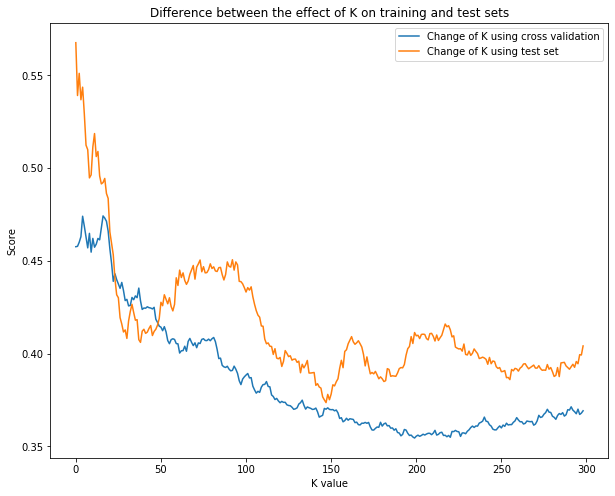

In [88]:
plt.figure(figsize=(10, 8))

plt.plot(score_list, label='Change of K using cross validation')
plt.plot(test_score_list, label='Change of K using test set')
plt.legend(loc='upper right')
plt.ylabel('Score')

plt.title('Difference between the effect of K on training and test sets')
plt.xlabel('K value')
plt.show()

In [0]:
#pred_df.to_csv(DATA / "predictions/best.csv")

In [0]:
#score_submission(pred_df, pfs_test) # comment later

We see the concordance index between our risk score and survival time is `0.4240`. This will be the baseline score. You should try to build models achieving **smaller** numbers using the hints mentioned before.